In [1]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

In [58]:
# random rottaion matrix
def random_rotation_matrix():
    R = np.random.rand(3, 3)
    Q, R = np.linalg.qr(R)
    R = np.diag(np.sign(np.diag(R)))
    if np.linalg.det(R) < 0:
        R[0, 0] *= -1
    return np.dot(Q, R)


R = random_rotation_matrix()
print(np.linalg.det(R))

unit_vec = np.array([1, 2, 3]) / np.linalg.norm(np.array([1, 2, 3]))
unit_vec

d = 10
rot_vec = (R @ unit_vec.reshape(3, 1)) * d

assert np.allclose(np.linalg.norm(rot_vec), d)

1.0000000000000002


In [41]:
# x = [p,v,a]
# u = [a]
# y = [p]

A = [[0, 1, 0],
     [0, 0, 1],
     [0, 0, 0]]
B = [[0],
     [0],
     [0]]
C = [[1, 0, 0],
     [0, 0, 1]]
D = [[0], [0]]

sys = ct.ss(A, B, C, D)
obs = ct.obsv(sys.A, sys.C)
print("Obs:", np.linalg.matrix_rank(obs))

comb = np.concatenate([A, B], axis=1)
comb = np.concatenate([comb, np.zeros((1, 4))], axis=0)

# generate trajectory p(t)
end = 60
samples = end*200
t = np.linspace(0, end, samples)
p = np.sin(t)
v = np.cos(t)
a = -np.sin(t)
a_bias = 0.0
ya = a + a_bias + 0.1*np.random.randn(samples)
yp = p + 0.1*np.random.randn(samples)

# discretize
dt = t[1] - t[0]
print("dt:", dt)
la.expm(comb*dt)
Ad = la.expm(comb*dt)[:3, :3]
Bd = la.expm(comb*dt)[:3, 3:]
Ad, Bd

Obs: 3
dt: 0.005000416701391783


(array([[1.00000000e+00, 5.00041670e-03, 1.25020836e-05],
        [0.00000000e+00, 1.00000000e+00, 5.00041670e-03],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[0.],
        [0.],
        [0.]]))

In [42]:
# Define the system matrices
F = Ad

H = np.array(C)

Q = np.array([[9.21211072e-07, -7.23768309e-07,  7.74261456e-06],
              [-7.23768309e-07,  1.34108239e-06,  2.31230191e-05],
              [7.74261456e-06,  2.31230191e-05,  1.18560562e-03],])
R = np.array([[0.01516054, -0.01457685],
              [-0.01457685,  0.02056665],])

# # Process noise covariance
# Q = np.diag([.1, .2, .1])

# # Measurement noise covariance
# R = np.diag([.1, .1])

# Initial state estimate
x_hat = np.array([[0], [1], [0]])

# Initial error covariance
P = np.eye(3) * 100

H @ x_hat, yp[0]

record = np.zeros((len(p), 3))
pos_modulo = int(np.ceil(0.033/dt))
# Kalman Filter loop
for i in range(len(p)):
    # Predict step
    x_hat = F @ x_hat
    P = F @ P @ F.T + Q

    # Position update
    if i % pos_modulo == 0 and i < len(p)//2:
        Hp = H[0, :].reshape(1, 3)
        K = P @ Hp.T @ np.linalg.inv(Hp @ P @ Hp.T + R[0, 0])
        x_hat = x_hat + K @ (yp[i] - Hp @ x_hat)
        P = (np.eye(3) - K @ Hp) @ P

    # Acceleration update
    Ha = H[1, :].reshape(1, 3)
    K = P @ Ha.T @ np.linalg.inv(Ha @ P @ Ha.T + R[1, 1])
    x_hat = x_hat + K @ (ya[i] - Ha @ x_hat)
    P = (np.eye(3) - K @ Ha) @ P

    # # mutual update
    # Hm = H
    # K = P @ Hm.T @ np.linalg.inv(Hm @ P @ Hm.T + R)
    # x_hat = x_hat + K @ (np.array([[yp[i]], [ya[i]]]) - Hm @ x_hat)
    # P = (np.eye(3) - K @ Hm) @ P

    record[i, :] = x_hat.T

In [44]:
# print error statistics of estimation
print("Error statistics (RMSE):")
print("p:", np.sqrt(np.mean((record[:, 0] - p)**2)))
print("v:", np.sqrt(np.mean((record[:, 1] - v)**2)))
print("a:", np.sqrt(np.mean((record[:, 2] - a)**2)))

Error statistics (RMSE):
p: 0.0936925751311109
v: 0.03359284319779895
a: 0.03676090257341262


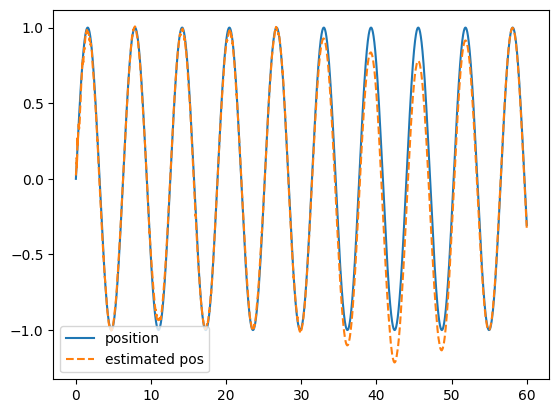

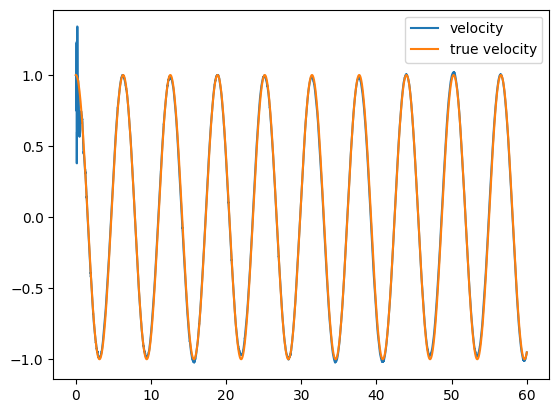

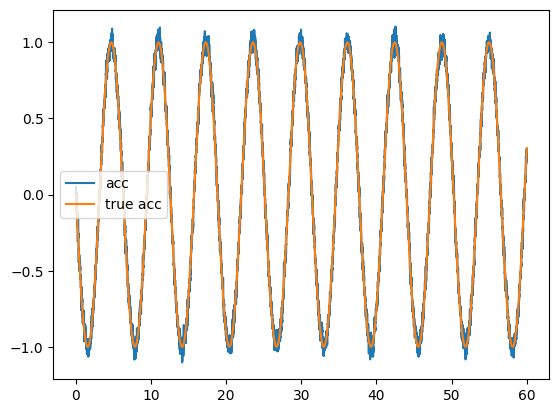

In [45]:
# plt.figure(dpi=200)
plt.plot(t,p, label='position')
plt.plot(t,record[:, 0], label='estimated pos', linestyle='dashed')
# plt.scatter(np.arange(0, len(p), end), yp[::end], label='measured', marker='x', c='g')
plt.legend()
# velocity
plt.figure()
plt.plot(t, record[:, 1], label='velocity')
plt.plot(t, v, label='true velocity')
plt.legend()
plt.figure()
plt.plot(t, record[:, 2], label='acc')
plt.plot(t, a, label='true acc')
plt.legend()